In [1]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.data import CLRSDataset
from torch.utils.data import DataLoader
from algo_reasoning.src.data import CLRSData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

/Users/ronaldalbert/miniconda3/envs/algo_reasoning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
algos = [
    'articulation_points',
    'activity_selector',
    'bellman_ford',
    'bfs',
    'binary_search',
    'bubble_sort',
    'dag_shortest_paths',
    'dfs',
    'dijkstra',
    'find_maximum_subarray_kadane',
    'floyd_warshall',
    'graham_scan',
    'heapsort',
    'insertion_sort',
    'jarvis_march',
    'kmp_matcher',
    'matrix_chain_order',
    'minimum',
    'mst_kruskal',
    'mst_prim',
    'naive_string_matcher',
    'optimal_bst',
    'quickselect',
    'quicksort',
    'segments_intersect',
    'strongly_connected_components',
    'task_scheduling',
    'topological_sort',
]

# Helper Functions

In [3]:
def calculate_embedding_similarities(embedding, embedding_generalist):
    embedding_similarities = []

    for i in range(len(embedding)):
        embedding_similarities.append([])
        embedding1 = embedding[i].detach().cpu()
        embedding2 = embedding_generalist[i].detach().cpu()
    
        for j in range(embedding1.shape[0]):
            for k in range(embedding2.shape[0]):
                embedding_similarities[i].append(F.cosine_similarity(embedding1[j], embedding2[k]).mean().item())

    sim_df = pd.DataFrame(embedding_similarities)

    return sim_df

# Three Kinds Dice

## Load Dataset and Models

In [3]:
algorithms = ["three_kinds_dice"]
three_kinds_dice_ds = CLRSDataset(algorithms, "train", "tmp/CLRS30")

algorithms2 = ["jarvis_march"]
jarvis_march_ds = CLRSDataset(algorithms2, "train", "tmp/CLRS30")

In [ ]:
processor = EncodeProcessDecode(algos).to(torch.device("cpu")).processor
state_dict = torch.load("checkpoints/Generalist_GMPNN_WithoutTeacherForcing/Generalist_GMPNN_WithoutTeacherForcing-epoch=95-val_loss=0.39.ckpt", map_location=torch.device("cpu"))["state_dict"]
new_state_dict = {}
for key in state_dict:
    if "processor" in key:
        new_state_dict[key.replace("model.processor.", "")] = state_dict[key]

processor.load_state_dict(new_state_dict)

generalist_model = EncodeProcessDecode(algos, pretrained_processor=processor).to(torch.device("cpu"))

pretrained_state_dict = torch.load("checkpoints/ThreeKindsDice_Pretrained/ThreeKindsDice_Pretrained-epoch=92-val_loss=0.02.ckpt", map_location=torch.device("cpu"))["state_dict"]
state_dict = torch.load("checkpoints/ThreeKindsDice_NotPretrained/ThreeKindsDice_NotPretrained-epoch=89-val_loss=0.02.ckpt", map_location=torch.device("cpu"))["state_dict"]

new_state_dict = {}
new_pretrained_state_dict = {}
for key in state_dict:
    if "model" in key:
        new_state_dict[key.replace("model.", "")] = state_dict[key]
        new_pretrained_state_dict[key.replace("model.", "")] = pretrained_state_dict[key]
pretrained_three_kinds_dice_model = EncodeProcessDecode(algorithms).to(torch.device("cpu"))
three_kinds_dice_model = EncodeProcessDecode(algorithms).to(torch.device("cpu"))
pretrained_three_kinds_dice_model.load_state_dict(new_pretrained_state_dict)
three_kinds_dice_model.load_state_dict(new_state_dict)

In [ ]:
generalist_model.eval()
pretrained_three_kinds_dice_model.eval()
three_kinds_dice_model.eval()

## Calculate model's vector embeddings

In [6]:
hidden_embedding_three_kinds_dice = []
hidden_embedding_pretrained_three_kinds_dice = []

hidden_embedding_generalist = []

with torch.no_grad():
    for i in range(len(three_kinds_dice_ds)):
        sample = three_kinds_dice_ds[i]
        output, hidden_embeddings = three_kinds_dice_model(sample.to(torch.device("cpu")))
        hidden_embedding_three_kinds_dice.append(hidden_embeddings)

        output, pretrained_hidden_embeddings = pretrained_three_kinds_dice_model(sample.to(torch.device("cpu")))
        hidden_embedding_pretrained_three_kinds_dice.append(pretrained_hidden_embeddings)
    
        jarvis_march_input = CLRSData(inputs=CLRSData(pos=sample.inputs.pos, x=sample.hints.score_D1[:, 0, :], y=sample.hints.score_D2[:, 0, :]), 
                                      hints=CLRSData(), 
                                      length=torch.tensor(50).float(), 
                                      max_length=torch.tensor(50).float(),
                                      outputs=CLRSData(), 
                                      algorithm="jarvis_march")
        
        output_jarvis_march, hidden_embeddings_jarvis_march = generalist_model(jarvis_march_input.to(torch.device("cpu")))
        hidden_embedding_generalist.append(hidden_embeddings_jarvis_march)

## Calculate Embedding's Similarities

In [8]:
pretrained_sim_df = calculate_embedding_similarities(hidden_embedding_pretrained_three_kinds_dice, hidden_embedding_generalist)
sim_df = calculate_embedding_similarities(hidden_embedding_three_kinds_dice, hidden_embedding_generalist)

In [ ]:
plt.plot(sim_df.mean(), label="Avg Sim-Not Pretrained")
plt.plot(pretrained_sim_df.mean(), label="Avg Sim-Pretrained")
plt.legend()
plt.show()

In [ ]:
plt.plot(sim_df.std(), label="Std Sim-Non Pretrained")
plt.plot(pretrained_sim_df.std(), label="Std Sim-Pretrained")
plt.legend()

# Carl's Vacation

## Load Dataset and Models

In [4]:
algorithms = ["carls_vacation"]
carls_vacation_ds = CLRSDataset(algorithms, "train", "tmp/CLRS30")

algorithms2 = ["segments_intersect"]
segments_intersect_ds = CLRSDataset(algorithms2, "train", "tmp/CLRS30")

In [5]:
state_dict = torch.load("checkpoints/SegmentsIntersect_Pretrained_FreezeProcessor/SegmentsIntersect_Pretrained_FreezeProcessor-epoch=93-val_loss=0.52.ckpt", map_location=torch.device("cpu"))["state_dict"]
new_state_dict = {}
for key in state_dict:
    if "model" in key:
        new_state_dict[key.replace("model.", "")] = state_dict[key]

generalist_model = EncodeProcessDecode(algorithms2).to(torch.device("cpu"))
generalist_model.load_state_dict(new_state_dict)

pretrained_state_dict = torch.load("checkpoints/CarlsVacation_Pretrained/CarlsVacation_Pretrained-epoch=98-val_loss=1398.56.ckpt", map_location=torch.device("cpu"))["state_dict"]
state_dict = torch.load("checkpoints/CarlsVacation_NotPretrained/CarlsVacation_NotPretrained-epoch=98-val_loss=1151.06.ckpt", map_location=torch.device("cpu"))["state_dict"]

new_state_dict = {}
new_pretrained_state_dict = {}
for key in state_dict:
    if "model" in key:
        new_state_dict[key.replace("model.", "")] = state_dict[key]
        new_pretrained_state_dict[key.replace("model.", "")] = pretrained_state_dict[key]
pretrained_carls_vacation_model = EncodeProcessDecode(algorithms).to(torch.device("cpu"))
carls_vacation_model = EncodeProcessDecode(algorithms).to(torch.device("cpu"))
pretrained_carls_vacation_model.load_state_dict(new_pretrained_state_dict)
carls_vacation_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [6]:
pretrained_carls_vacation_model.eval()
carls_vacation_model.eval()
generalist_model.eval()

EncodeProcessDecode(
  (encoders): ModuleDict(
    (segments_intersect): Encoder(
      (encoder): ModuleDict(
        (pos): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (x): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (y): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (i): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (j): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (k): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (dir): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (on_seg): LinearEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
      )
    )
  )
  (decoders): 

In [7]:
hidden_embedding_carls_vacation = []
hidden_embedding_pretrained_carls_vacation = []

hidden_embedding_generalist1 = []
hidden_embedding_generalist2 = []

with torch.no_grad():
    for i in range(len(carls_vacation_ds)):
        sample = carls_vacation_ds[i]
        output, hidden_embeddings = carls_vacation_model(sample.to(torch.device("cpu")))
        hidden_embedding_carls_vacation.append(hidden_embeddings)

        output, pretrained_hidden_embeddings = pretrained_carls_vacation_model(sample.to(torch.device("cpu")))
        hidden_embedding_pretrained_carls_vacation.append(pretrained_hidden_embeddings)

        input_x = sample.hints
    
        segments_intersect_input1 = CLRSData(inputs=CLRSData(pos=sample.inputs.pos, x=sample.hints.tops_segment1_x[:, 1], y=sample.hints.tops_segment1_y[:, 1]), 
                                      hints=CLRSData(), 
                                      length=torch.tensor(50).float(), 
                                      max_length=torch.tensor(50).float(),
                                      outputs=CLRSData(), 
                                      algorithm="segments_intersect")
        
        segments_intersect_input2 = CLRSData(inputs=CLRSData(pos=sample.inputs.pos, x=sample.hints.tops_segment2_x[:, 1], y=sample.hints.tops_segment2_y[:, 1]), 
                                      hints=CLRSData(), 
                                      length=torch.tensor(50).float(), 
                                      max_length=torch.tensor(50).float(),
                                      outputs=CLRSData(), 
                                      algorithm="segments_intersect")
        
        _, hidden_embeddings_segments_intersect1 = generalist_model(segments_intersect_input1.to(torch.device("cpu")))
        _, hidden_embeddings_segments_intersect2 = generalist_model(segments_intersect_input2.to(torch.device("cpu")))

        hidden_embedding_generalist1.append(hidden_embeddings_segments_intersect1)
        hidden_embedding_generalist2.append(hidden_embeddings_segments_intersect2)

In [8]:
pretrained_sim_df = calculate_embedding_similarities(hidden_embedding_pretrained_carls_vacation, hidden_embedding_generalist1)
sim_df = calculate_embedding_similarities(hidden_embedding_carls_vacation, hidden_embedding_generalist1)

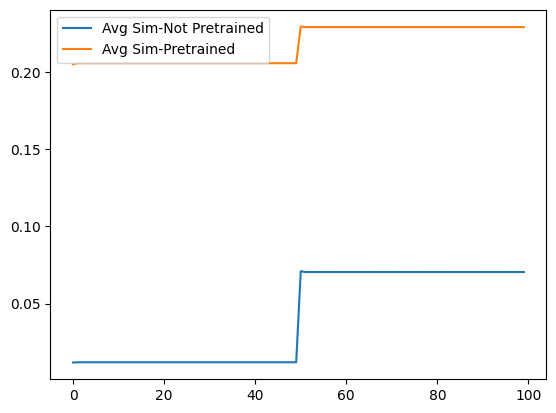

In [9]:
plt.plot(sim_df.mean(), label="Avg Sim-Not Pretrained")
plt.plot(pretrained_sim_df.mean(), label="Avg Sim-Pretrained")
plt.legend()
plt.show()

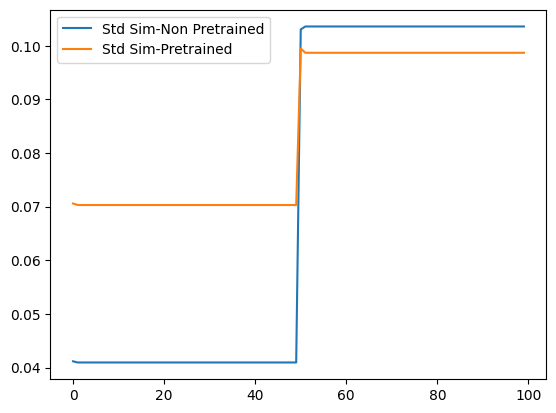

In [10]:
plt.plot(sim_df.std(), label="Std Sim-Non Pretrained")
plt.plot(pretrained_sim_df.std(), label="Std Sim-Pretrained")
plt.legend()

In [11]:
pretrained_sim_df = calculate_embedding_similarities(hidden_embedding_pretrained_carls_vacation, hidden_embedding_generalist2)
sim_df = calculate_embedding_similarities(hidden_embedding_carls_vacation, hidden_embedding_generalist2)

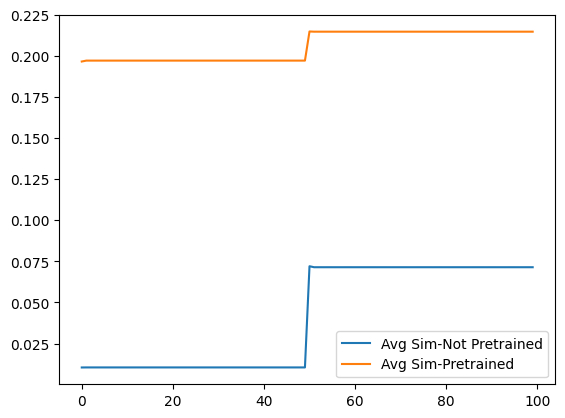

In [12]:
plt.plot(sim_df.mean(), label="Avg Sim-Not Pretrained")
plt.plot(pretrained_sim_df.mean(), label="Avg Sim-Pretrained")
plt.legend()
plt.show()

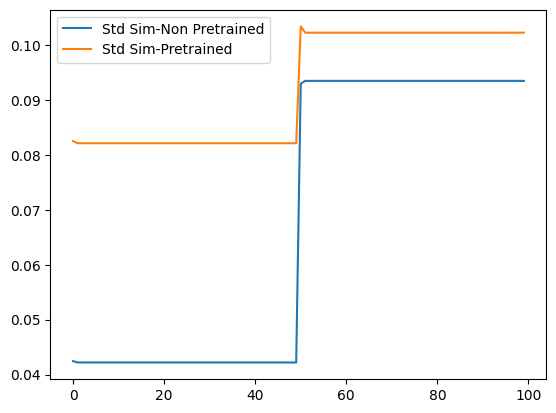

In [13]:
plt.plot(sim_df.std(), label="Std Sim-Non Pretrained")
plt.plot(pretrained_sim_df.std(), label="Std Sim-Pretrained")
plt.legend()